##  **Dataset Source**

We used the [CyberBERT Dataset](https://huggingface.co/datasets/agrawalchaitany/cyberbert_dataset), which is publicly available on Hugging Face .

###  Description:
* The dataset contains a wide range of **network traffic features** used for **cybersecurity threat detection**.
* It includes both **normal (BENIGN)** traffic and **various attack types** such as DoS, PortScan, DDoS, and more.
* Each row represents a network flow with detailed statistical features (e.g., packet length, flow duration, header size).

###  Access Method:
* We loaded the dataset directly using the  `datasets` library in Python:
```python
from datasets import load_dataset
dataset = load_dataset("agrawalchaitany/cyberbert_dataset")

In [3]:
import pandas as pd
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import load_model

from sklearn.metrics import f1_score, precision_score, recall_score


dataset = load_dataset("agrawalchaitany/cyberbert_dataset")

# **1. Data Handling**



## Data Cleaning and Preprocessing



###  **Dealing with Missing or Redundant Features**

To ensure that only meaningful features are included in our model, we examined the dataset for missing values, duplicated features, and uninformative columns.

We performed a correlation analysis and identified several pairs of features with a perfect correlation of 1.0. After comparing them directly, we found that some were completely identical — containing the exact same values row by row — so we safely dropped the duplicates.

Additionally, some columns contained only zeros or constant values across all rows, making them uninformative for classification. These columns were also removed to reduce noise and simplify the model.


In [4]:
df = dataset['train'].to_pandas()
pd.set_option('display.max_columns', None)

df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,33.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,9174.311927,9174.311927,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,19230.769230,19230.769230,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,29.0,256.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,29411.764710,29411.764710,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,9.0,6.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,6.0,31.0,329.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9.0,6.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,0.0,0.0,32.0,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [5]:
df['Destination Port'].nunique()

53805

In [6]:
df.shape

(2522362, 79)

# catigorical vaalues 

In [7]:
categorical_cols = []

for col in df.columns:
    unique_vals = df[col].nunique()
    dtype = df[col].dtype

    print(f"{col}: {unique_vals} unique values | Type: {dtype}")

    # نعتبره كاتيجوري إذا:
    if unique_vals <= 10 or dtype == 'object':
        categorical_cols.append(col)

    # أو إذا نوعه int وعدد القيم الفريدة محدود (≤20)
    elif dtype in ['int64', 'int32'] and unique_vals <= 20:
        categorical_cols.append(col)

print("\n✅ Final Categorical Columns:", categorical_cols)

Destination Port: 53805 unique values | Type: float64
Flow Duration: 1050899 unique values | Type: float64
Total Fwd Packets: 1432 unique values | Type: float64
Total Backward Packets: 1747 unique values | Type: float64
Total Length of Fwd Packets: 17928 unique values | Type: float64
Total Length of Bwd Packets: 64698 unique values | Type: float64
Fwd Packet Length Max: 5279 unique values | Type: float64
Fwd Packet Length Min: 384 unique values | Type: float64
Fwd Packet Length Mean: 99716 unique values | Type: float64
Fwd Packet Length Std: 253909 unique values | Type: float64
Bwd Packet Length Max: 4838 unique values | Type: float64
Bwd Packet Length Min: 583 unique values | Type: float64
Bwd Packet Length Mean: 147614 unique values | Type: float64
Bwd Packet Length Std: 248869 unique values | Type: float64
Flow Bytes/s: 1593908 unique values | Type: float64
Flow Packets/s: 1240164 unique values | Type: float64
Flow IAT Mean: 1166311 unique values | Type: float64
Flow IAT Std: 105664

In [8]:
binary_cols = []
multiclass_categorical_cols = []
continuous_cols = []

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    num_unique = len(unique_vals)
    
    if df[col].dtype in ['int64', 'float64']:
        if num_unique == 2 and set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)
        elif num_unique <= 15:
            multiclass_categorical_cols.append(col)
        else:
            continuous_cols.append(col)

print("🔹 Binary Columns:", binary_cols)
print("🔸 Multiclass Categorical Columns:", multiclass_categorical_cols)
print("🟡 Continuous Columns:", continuous_cols)

🔹 Binary Columns: ['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count']
🔸 Multiclass Categorical Columns: ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
🟡 Continuous Columns: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd

In [9]:
df['ACK Flag Count'].value_counts()

ACK Flag Count
0.0    1734912
1.0     787450
Name: count, dtype: int64

In [10]:
df['FIN Flag Count'].value_counts()

FIN Flag Count
0.0    2441276
1.0      81086
Name: count, dtype: int64

In [11]:
df['RST Flag Count'].value_counts()

RST Flag Count
0.0    2521676
1.0        686
Name: count, dtype: int64

In [12]:
df['PSH Flag Count'].value_counts()

PSH Flag Count
0.0    1771911
1.0     750451
Name: count, dtype: int64

In [13]:
df['URG Flag Count'].value_counts()

URG Flag Count
0.0    2266525
1.0     255837
Name: count, dtype: int64

In [14]:
df['Destination Port'].max()

np.float64(65535.0)

In [15]:
df['Destination Port'].min()

np.float64(0.0)

In [16]:

port_80_count = (df['Destination Port'] == 80).sum()
port_80_count

np.int64(542342)

Destination Port


In [17]:
df['Label'].value_counts()

Label
BENIGN                        2096484
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [18]:
df.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [19]:

dos_hulk_df = df[df['Label'] == 'DoS Hulk']

dos_hulk_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
2001598,80.0,1878.0,3.0,6.0,382.0,11595.0,382.0,0.0,127.333333,220.547803,4355.0,0.0,1932.500000,2182.468304,6377529.286,4792.332268,234.750000,229.129876,577.0,15.0,975.0,487.500000,265.165043,675.0,300.0,1780.0,356.000000,399.788069,950.0,15.0,0.0,0.0,0.0,0.0,104.0,200.0,1597.444089,3194.888179,0.0,4355.0,1197.700000,1886.332364,3558249.789,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1330.777778,127.333333,1932.500000,104.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,382.0,6.0,11595.0,29200.0,235.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk
2001599,80.0,1550.0,3.0,6.0,372.0,11595.0,372.0,0.0,124.000000,214.774300,5792.0,0.0,1932.500000,2537.820147,7720645.161,5806.451613,193.750000,262.939836,658.0,3.0,669.0,334.500000,402.343758,619.0,50.0,1503.0,300.600000,366.313800,742.0,3.0,0.0,0.0,0.0,0.0,104.0,200.0,1935.483871,3870.967742,0.0,5792.0,1196.700000,2119.419944,4491940.900,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1329.666667,124.000000,1932.500000,104.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,372.0,6.0,11595.0,29200.0,235.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk
2001600,80.0,497.0,4.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000,8048.289738,165.666667,153.206832,304.0,1.0,497.0,165.666667,153.206832,304.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,8048.289738,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,128.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,251.0,-1.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk
2001601,80.0,1893.0,3.0,7.0,348.0,11595.0,348.0,0.0,116.000000,200.917894,4344.0,0.0,1656.428571,1760.597234,6309033.281,5282.620180,210.333333,237.859202,769.0,3.0,967.0,483.500000,584.777308,897.0,70.0,1765.0,294.166667,351.901928,956.0,3.0,0.0,0.0,0.0,0.0,104.0,232.0,1584.786054,3697.834126,0.0,4344.0,1085.727273,1579.834427,2495876.818,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1194.300000,116.000000,1656.428571,104.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,348.0,7.0,11595.0,29200.0,235.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk
2001602,80.0,1942.0,3.0,6.0,351.0,11595.0,351.0,0.0,117.000000,202.649945,5803.0,0.0,1932.500000,2539.075088,6151390.319,4634.397528,242.750000,457.036025,1348.0,2.0,1455.0,727.500000,939.744912,1392.0,63.0,1898.0,379.600000,625.954711,1477.0,2.0,0.0,0.0,0.0,0.0,104.0,200.0,1544.799176,3089.598352,0.0,5803.0,1194.600000,2121.172590,4499373.156,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1327.333333,117.000000,1932.500000,104.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,351.0,6.0,11595.0,29200.0,235.0,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DoS Hulk


In [20]:
duplicates = df.duplicated().sum()
print(f"duplicat: {duplicates}")

duplicat: 0


In [21]:
df[['Total Fwd Packets', 'Total Length of Fwd Packets']].corr()

,Total Fwd Packets,Total Length of Fwd Packets
Total Fwd Packets,1.00000,0.36551
Total Length of Fwd Packets,0.36551,1.00000


In [22]:
df[['Subflow Bwd Bytes', 'Total Length of Bwd Packets']].corr()

,Subflow Bwd Bytes,Total Length of Bwd Packets
Subflow Bwd Bytes,1.0,1.0
Total Length of Bwd Packets,1.0,1.0


In [23]:
#we need to delet one of them 	Fwd Packet Length Mean  or Avg Fwd Segment Size	

df[['Fwd Packet Length Mean', 'Avg Fwd Segment Size', 'Average Packet Size']].corr()

,Fwd Packet Length Mean,Avg Fwd Segment Size,Average Packet Size
Fwd Packet Length Mean,1.000000,1.000000,0.299532
Avg Fwd Segment Size,1.000000,1.000000,0.299532
Average Packet Size,0.299532,0.299532,1.000000


In [24]:
df[
    ['Fwd Header Length', 'Fwd Header Length.1',
     'Total Length of Fwd Packets', 'Subflow Fwd Bytes',
     'Packet Length Mean', 'Average Packet Size',
     'Packet Length Variance', 'Packet Length Std',
     'Fwd Packet Length Mean', 'Avg Fwd Segment Size']
].corr()



,Fwd Header Length,Fwd Header Length.1,Total Length of Fwd Packets,Subflow Fwd Bytes,Packet Length Mean,Average Packet Size,Packet Length Variance,Packet Length Std,Fwd Packet Length Mean,Avg Fwd Segment Size
Fwd Header Length,1.000000,1.000000,-0.001338,-0.001339,0.000508,0.000545,0.000418,0.000642,-0.000056,-0.000056
Fwd Header Length.1,1.000000,1.000000,-0.001338,-0.001339,0.000508,0.000545,0.000418,0.000642,-0.000056,-0.000056
Total Length of Fwd Packets,-0.001338,-0.001338,1.000000,0.999999,0.081365,0.076025,0.033850,0.057367,0.185073,0.185073
Subflow Fwd Bytes,-0.001339,-0.001339,0.999999,1.000000,0.081472,0.076126,0.033896,0.057445,0.185317,0.185317
Packet Length Mean,0.000508,0.000508,0.081365,0.081472,1.000000,0.997822,0.805559,0.942703,0.297478,0.297478
Average Packet Size,0.000545,0.000545,0.076025,0.076126,0.997822,1.000000,0.816780,0.943132,0.299532,0.299532
Packet Length Variance,0.000418,0.000418,0.033850,0.033896,0.805559,0.816780,1.000000,0.924930,0.211705,0.211705
Packet Length Std,0.000642,0.000642,0.057367,0.057445,0.942703,0.943132,0.924930,1.000000,0.279416,0.279416
Fwd Packet Length Mean,-0.000056,-0.000056,0.185073,0.185317,0.297478,0.299532,0.211705,0.279416,1.000000,1.000000
Avg Fwd Segment Size,-0.000056,-0.000056,0.185073,0.185317,0.297478,0.299532,0.211705,0.279416,1.000000,1.000000


In [25]:

df_numeric = df.drop(columns=['Label'])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_numeric.corr()




,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
Destination Port,1.000000,-0.171828,-0.004652,-0.004356,0.009611,-0.003388,0.090989,-0.047160,0.136916,0.123060,-0.212699,-0.262417,-0.238842,-0.190515,0.070287,0.359537,-0.113636,-0.131931,-0.130869,-0.023383,-0.171004,-0.107032,-0.111044,-0.129597,-0.055521,-0.119856,-0.075871,-0.041670,-0.061670,-0.055113,0.234993,NaN,0.004445,NaN,0.000457,0.000761,0.348251,0.143760,-0.255221,-0.143499,-0.171428,-0.139519,-0.077536,-0.036841,0.234993,-0.007134,-0.217887,0.585195,0.523381,0.004445,-0.007044,0.027562,-0.172832,0.136916,-0.238842,0.000457,NaN,NaN,NaN,NaN,NaN,NaN,-0.004652,0.009624,-0.004356,-0.003388,-0.133049,0.206231,-0.003543,0.001003,-0.040678,-0.048227,-0.058142,-0.027193,-0.127989,0.006732,-0.123677,-0.129539
Flow Duration,-0.171828,1.000000,0.020571,0.019389,0.063509,0.015998,0.263401,-0.115716,0.134033,0.224957,0.485858,-0.238692,0.448503,0.433671,-0.024982,-0.109900,0.534831,0.734884,0.779979,0.060566,0.998529,0.543119,0.721063,0.779716,0.209850,0.819887,0.408650,0.517722,0.580336,0.212795,-0.017047,NaN,-0.002651,NaN,-0.000097,-0.001049,-0.099488,-0.080348,-0.247385,0.501514,0.417241,0.445197,0.271962,0.217883,-0.017047,0.008075,0.179773,0.033256,-0.117224,-0.002651,0.008023,-0.165840,0.394800,0.134033,0.448503,-0.000097,NaN,NaN,NaN,NaN,NaN,NaN,0.020571,0.063592,0.019389,0.015998,0.094089,-0.034352,0.015728,-0.001236,0.184985,0.238497,0.289933,0.117259,0.764124,0.240369,0.775744,0.734123
Total Fwd Packets,-0.004652,0.020571,1.000000,0.999070,0.365510,0.996993,0.009071,-0.003255,-0.000262,0.001110,0.022552,-0.006068,0.021123,0.006045,0.000391,-0.002342,-0.001366,-0.000954,0.001862,-0.000589,0.020240,-0.001361,-0.000333,0.001418,-0.001290,0.023794,-0.000883,0.000475,0.003095,-0.001144,0.001882,NaN,-0.000059,NaN,0.000476,0.013750,-0.002132,-0.001655,-0.006792,0.021735,0.024239,0.011654,0.005141,-0.001337,0.001882,0.000339,0.007061,0.001378,-0.003794,-0.000059,0.000337,0.000882,0.021865,-0.000262,0.021123,0.000476,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.365992,0.999070,0.996987,0.003729,-0.000658,0.887386,-0.000181,0.039822,0.008207,0.030318,0.041186,0.001402,0.000676,0.001483,0.001266
Total Backward Packets,-0.004356,0.019389,0.999070,1.000000,0.359457,0.994430,0.008764,-0.002834,-0.000617,0.000743,0.022342,-0.005343,0.021244,0.005722,0.000335,-0.002383,-0.001711,-0.001426,0.001406,-0.000615,0.019040,-0.001541,-0.000860,0.000947,-0.001160,0.023219,-0.001039,0.000272,0.003177,-0.001100,0.001673,NaN,-0.000061,NaN,0.000757,0.013766,-0.002231,-0.001369,-0.006152,0.021469,0.024655,0.011508,0.005111,-0.001183,0.001673,0.000214,0.006490,0.001203,-0.003151,-0.000061,0.000213,0.003279,0.022290,-0.000617,0.021244,0.000757,NaN,NaN,NaN,NaN,NaN,NaN,0.999070,0

In [26]:


df_numeric = df.drop(columns=['Label'])


corr_matrix = df_numeric.corr()


perfect_corr_rows = []

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and corr_matrix.loc[col1, col2] == 1.0:
            pair = tuple(sorted((col1, col2)))  
            perfect_corr_rows.append(pair)


perfect_corr_unique = list(set(perfect_corr_rows))


perfect_corr_df = pd.DataFrame(perfect_corr_unique, columns=["Feature 1", "Feature 2"])
perfect_corr_df["Correlation"] = 1.0


perfect_corr_df

,Feature 1,Feature 2,Correlation
0,Subflow Fwd Packets,Total Fwd Packets,1.0
1,CWE Flag Count,Fwd URG Flags,1.0
2,Fwd PSH Flags,SYN Flag Count,1.0
3,Avg Fwd Segment Size,Fwd Packet Length Mean,1.0
4,Subflow Bwd Packets,Total Backward Packets,1.0
5,Fwd Header Length,Fwd Header Length.1,1.0


In [27]:
#delet
df['Bwd PSH Flags'].value_counts()

Bwd PSH Flags
0.0    2522362
Name: count, dtype: int64

In [28]:
# delet
df['Bwd URG Flags'].value_counts()

Bwd URG Flags
0.0    2522362
Name: count, dtype: int64

In [29]:
#we need to delet them
bulk_columns = [
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
]

for col in bulk_columns:
    print(df[col].value_counts())  

Fwd Avg Bytes/Bulk
0.0    2522362
Name: count, dtype: int64
Fwd Avg Packets/Bulk
0.0    2522362
Name: count, dtype: int64
Fwd Avg Bulk Rate
0.0    2522362
Name: count, dtype: int64
Bwd Avg Bytes/Bulk
0.0    2522362
Name: count, dtype: int64
Bwd Avg Packets/Bulk
0.0    2522362
Name: count, dtype: int64
Bwd Avg Bulk Rate
0.0    2522362
Name: count, dtype: int64


In [30]:

bad_rows = df[
    (df["Flow Bytes/s"].isin([np.inf, -np.inf])) |
    (df["Flow Packets/s"].isin([np.inf, -np.inf])) |
    (df["Flow Bytes/s"].isna()) |
    (df["Flow Packets/s"].isna())
]

print(bad_rows['Label'].value_counts())

Label
BENIGN         1427
PortScan        125
Bot               5
DoS Hulk          3
DDoS              2
FTP-Patator       2
Name: count, dtype: int64


In [31]:


"""
Checking for exact equality between pairs of features that showed perfect correlation (1.0).
This step helps verify whether the features are truly duplicates (identical values row by row)
or just mathematically correlated (e.g., multiples or derived values).
If the result is True, the features are completely identical and one of them can be safely dropped.
"""


print(" Subflow Bwd Packets == Total Backward Packets:", 
      (df['Subflow Bwd Packets'] == df['Total Backward Packets']).all())


print(" Fwd PSH Flags == SYN Flag Count:", 
      (df['Fwd PSH Flags'] == df['SYN Flag Count']).all())

print("CWE Flag Count == Fwd URG Flags:", 
      (df['CWE Flag Count'] == df['Fwd URG Flags']).all())

print(" Subflow Fwd Packets == Total Fwd Packets:", 
      (df['Subflow Fwd Packets'] == df['Total Fwd Packets']).all())


print(" Fwd Header Length == Fwd Header Length.1:", 
      (df['Fwd Header Length'] == df['Fwd Header Length.1']).all())


print(" Avg Fwd Segment Size == Fwd Packet Length Mean:", 
      (df['Avg Fwd Segment Size'] == df['Fwd Packet Length Mean']).all())

 Subflow Bwd Packets == Total Backward Packets: True
 Fwd PSH Flags == SYN Flag Count: True
CWE Flag Count == Fwd URG Flags: True
 Subflow Fwd Packets == Total Fwd Packets: True
 Fwd Header Length == Fwd Header Length.1: True
 Avg Fwd Segment Size == Fwd Packet Length Mean: False


### **Dealing with nagative values**



After exploring the dataset, we found that some numeric features contained negative values, which are logically incorrect in this context—such as negative time durations, speeds, or packet sizes. These values were mostly found in the `BENIGN` class, which dominates the dataset with over 2 million samples.

To ensure clean and reliable data, we decided to remove all rows that had negative values in the following columns:
`Flow Duration`, `Flow Bytes/s`, `Flow Packets/s`, `Flow IAT Mean`, `Flow IAT Max`, `Flow IAT Min`, `Fwd IAT Min`, `Fwd Header Length`, `Bwd Header Length`, and `min_seg_size_forward`.

For the column `Init_Win_bytes_forward`, we observed that more than 99% of its negative values appeared only in benign traffic. This made it non-informative and noisy for classification, so we removed both its negative rows and the column itself.

However, we kept the column `Init_Win_bytes_backward` because its negative values were more meaningfully distributed across both benign and attack labels—particularly DoS and DDoS attacks. We believe this variation might help the model learn useful patterns related to malicious activity.

In [32]:
negative_counts = {}

for col in df.select_dtypes(include='number').columns:
    count = (df[col] < 0).sum()
    if count > 0:
        negative_counts[col] = count


print(" Nagative values:")
for col, count in negative_counts.items():
    print(f"{col}: {count}")

 Nagative values:
Flow Duration: 107
Flow Bytes/s: 78
Flow Packets/s: 107
Flow IAT Mean: 107
Flow IAT Max: 107
Flow IAT Min: 2881
Fwd IAT Min: 17
Fwd Header Length: 35
Bwd Header Length: 22
Fwd Header Length.1: 35
Init_Win_bytes_forward: 911027
Init_Win_bytes_backward: 1216341
min_seg_size_forward: 35


In [33]:

negative_cols = [
    'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Min',
    'Fwd Header Length', 'Bwd Header Length', 'min_seg_size_forward'
]

for col in negative_cols:
    
    print(f" Column: '{col}'")

    negative_rows = df[df[col] < 0]
    print(f"→ Total negative values: {len(negative_rows)}")
  
    if not negative_rows.empty:
        label_dist = negative_rows['Label'].value_counts()
        for label, count in label_dist.items():
            print(f"   - {label}: {count}")
    else:
        print("   - No negative values found.")

 Column: 'Flow Duration'
→ Total negative values: 107
   - BENIGN: 107
 Column: 'Flow Bytes/s'
→ Total negative values: 78
   - BENIGN: 78
 Column: 'Flow Packets/s'
→ Total negative values: 107
   - BENIGN: 107
 Column: 'Flow IAT Mean'
→ Total negative values: 107
   - BENIGN: 107
 Column: 'Flow IAT Max'
→ Total negative values: 107
   - BENIGN: 107
 Column: 'Fwd IAT Min'
→ Total negative values: 17
   - DoS Hulk: 8
   - DDoS: 6
   - DoS GoldenEye: 3
 Column: 'Fwd Header Length'
→ Total negative values: 35
   - BENIGN: 35
 Column: 'Bwd Header Length'
→ Total negative values: 22
   - BENIGN: 22
 Column: 'min_seg_size_forward'
→ Total negative values: 35
   - BENIGN: 35


In [34]:

negative_rows_iat_min = df[df['Flow IAT Min'] < 0]

label_distribution = negative_rows_iat_min['Label'].value_counts()
print("Column: 'Flow IAT Min'")
print(f"→ Total negative values: {len(negative_rows_iat_min)}")
print("→ Label distribution:\n", label_distribution)

Column: 'Flow IAT Min'
→ Total negative values: 2881
→ Label distribution:
 Label
BENIGN           2688
DoS Hulk          158
DDoS               19
DoS GoldenEye       5
FTP-Patator         4
Heartbleed          4
SSH-Patator         2
Infiltration        1
Name: count, dtype: int64


In [35]:
# Define the columns where negative values are considered invalid
columns_to_clean = [
    'Flow Duration', 'Flow Bytes/s', 'Flow Packets/s',
    'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min',
    'Fwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'min_seg_size_forward'
]

# Remove rows that contain negative values in any of these columns
df = df[~(df[columns_to_clean] < 0).any(axis=1)]

In [36]:

"""
 Decision:

We decided to remove the column 'Init_Win_bytes_forward' because:
- Over 99% of its negative values occur in BENIGN traffic only.
- It does not help distinguish between normal and attack traffic.
- It adds noise and unnecessary complexity to the model without contributing valuable information.

On the other hand, we chose to keep  the column 'Init_Win_bytes_backward' because:
- Although it also contains many negative values, these appear across both BENIGN and various attack types.
- This variation may provide useful signals for classification, especially in detecting DoS and DDoS behaviors.
"""


cols_to_check = ['Init_Win_bytes_forward', 'Init_Win_bytes_backward']

for col in cols_to_check:
    print("="*60)
    print(f" Column: '{col}' — Negative Values per Label:")
    
    neg_rows = df[df[col] < 0]
    print(neg_rows['Label'].value_counts())

 Column: 'Init_Win_bytes_forward' — Negative Values per Label:
Label
BENIGN      910969
PortScan         7
Name: count, dtype: int64
 Column: 'Init_Win_bytes_backward' — Negative Values per Label:
Label
BENIGN              1153016
DDoS                  46524
DoS Hulk               9234
DoS Slowhttptest       3145
DoS GoldenEye          2572
DoS slowloris          1639
PortScan                 64
FTP-Patator              64
Web Attack � XSS         17
SSH-Patator              12
Infiltration              3
Name: count, dtype: int64


## Removed Features


In [37]:
# Dropping the column 'Fwd Header Length.1' because it's a duplicate of 'Fwd Header Length'
# It was automatically created when the dataset had two columns with the same name
df.drop(columns=['Fwd Header Length.1'], inplace=True)

# Dropping the column 'Avg Fwd Segment Size' because it has almost identical values to 'Fwd Packet Length Mean'
# Keeping both would be redundant, so we keep only one to reduce feature duplication
df.drop(columns=['Avg Fwd Segment Size'], inplace=True)

# Dropping bulk-related columns because all their values are zero,
df.drop(columns=bulk_columns, inplace=True)


# Dropping 'Bwd PSH Flags' column because it contains only zero or NaN values.
# From both a data and domain perspective, it provides no variance and no distinguishing signal
# between normal and attack traffic.

df.drop(columns=['Bwd PSH Flags'], inplace=True)


# Dropping Bwd URG Flags columns because all their values are zero,
df.drop(columns=['Bwd URG Flags'], inplace=True)


"""
Removing rows that contain NaN or infinite values in 'Flow Bytes/s' or 'Flow Packets/s'.
We checked the label distribution for these rows and found that most of them (1427 out of ~1500)
belong to the 'BENIGN' class, which is the dominant class in the dataset.
Considering the class imbalance, this removal does not significantly affect minority attack classes,
and helps clean up invalid values that could negatively impact model performance.
"""

df = df[
    ~df["Flow Bytes/s"].isin([np.inf, -np.inf]) &
    ~df["Flow Packets/s"].isin([np.inf, -np.inf]) &
    df["Flow Bytes/s"].notna() &
    df["Flow Packets/s"].notna()
]

# Dropping perfectly correlated features based on correlation = 1.0.
# These columns are either exact duplicates or carry redundant information.
# Subflow Bwd Packets is identical to Total Backward Packets
# Fwd PSH Flags has the same values as SYN Flag Count (unexpected, likely tool duplication)
# CWE Flag Count is the same as Fwd URG Flags (likely internal alias)
# Subflow Fwd Packets is identical to Total Fwd Packets
df.drop(columns=[
    'Subflow Bwd Packets',
    'Fwd PSH Flags',
    'CWE Flag Count',
    'Subflow Fwd Packets'
], inplace=True)

df.drop(columns=['Init_Win_bytes_forward'], inplace=True)


df.drop(columns=['Init_Win_bytes_backward'], inplace=True)

In [38]:
df['Label'].value_counts()

Label
BENIGN                        2092335
DoS Hulk                       172688
DDoS                           127995
PortScan                        90694
DoS GoldenEye                   10281
FTP-Patator                      5927
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3217
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       35
Web Attack � Sql Injection         21
Heartbleed                          7
Name: count, dtype: int64

In [39]:
print("Number of columns after cleaning:", df.shape[1])

Number of columns after cleaning: 63


In [40]:
print(df.columns.tolist())

['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Average Packet Size', 'Avg Bwd Segment Size', 'S

In [41]:
print(df.isna().sum()[df.isna().sum() > 0])

Series([], dtype: int64)


In [42]:
negative_counts = {}

for col in df.select_dtypes(include='number').columns:
    count = (df[col] < 0).sum()
    if count > 0:
        negative_counts[col] = count


print(" Nagative values:")
for col, count in negative_counts.items():
    print(f"{col}: {count}")

 Nagative values:


In [43]:
df["Label"].value_counts()

Label
BENIGN                        2092335
DoS Hulk                       172688
DDoS                           127995
PortScan                        90694
DoS GoldenEye                   10281
FTP-Patator                      5927
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3217
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       35
Web Attack � Sql Injection         21
Heartbleed                          7
Name: count, dtype: int64

In [44]:
numeric_df = df.select_dtypes(include='number')


In [45]:
nan_columns = numeric_df.columns[numeric_df.isna().any()]
print(" Columns with missing values (NaN):")
print(nan_columns.tolist() if len(nan_columns) else " No NaN values found.")


constant_columns = numeric_df.columns[numeric_df.nunique() <= 1]
print("\n Columns with constant or duplicate values:")
print(constant_columns.tolist() if len(constant_columns) else " No constant columns found.")

zero_columns = [col for col in numeric_df.columns if (numeric_df[col] == 0).all()]
print("\n Columns with all zeros:")
print(zero_columns if zero_columns else " No all-zero columns found.")

 Columns with missing values (NaN):
 No NaN values found.

 Columns with constant or duplicate values:
 No constant columns found.

 Columns with all zeros:
 No all-zero columns found.


In [46]:
df.shape

(2517883, 63)

In [47]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,12.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,9174.311927,9174.311927,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,6.0,6.0,6.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,19230.769230,19230.769230,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,6.0,6.0,6.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,29411.764710,29411.764710,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,6.0,6.0,6.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,12.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


##  Step: Feature Type Identification

In this step, we categorized each column in the dataset based on its values and data type to decide how to preprocess it later.

###  Binary Columns
- Contain only two values: 0 and 1.
- Already encoded → no further processing needed.

###  Multiclass Categorical Columns
- Non-numeric or numeric with a few unique values (less than 15).
- Will need encoding (e.g., One-Hot or Label Encoding).

###  Continuous Columns
- Numeric with many unique values.
- Will require transformations like scaling or log transformation.


In [48]:



binary_cols = []
multiclass_categorical_cols = []
continuous_cols = []

for col in df.columns:
    unique_vals = df[col].dropna().unique()
    num_unique = len(unique_vals)
    
    if df[col].dtype in ['int64', 'float64']:
        if num_unique == 2 and set(unique_vals).issubset({0, 1}):
            binary_cols.append(col)
        elif 2 < num_unique < 15:
            multiclass_categorical_cols.append(col)
        else:
            continuous_cols.append(col)
    else:
     
        multiclass_categorical_cols.append(col)


print(f"Binary Columns ({len(binary_cols)}): {binary_cols}")
print(f"Multiclass Categorical Columns ({len(multiclass_categorical_cols)}): {multiclass_categorical_cols}")
print(f"Continuous Columns ({len(continuous_cols)}): {continuous_cols}")

total_columns = len(binary_cols) + len(multiclass_categorical_cols) + len(continuous_cols)
print(f"\nTotal Columns: {total_columns}")

Binary Columns (8): ['Fwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count']
Multiclass Categorical Columns (1): ['Label']
Continuous Columns (54): ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean', 'Packet Length Std', 

In [49]:

important_ports = [21, 22, 23, 25, 53, 80, 110, 111, 135, 139,
                   143, 443, 445, 993, 995, 1723, 3306, 3389, 5900, 8080]

df['Destination Port Encoded'] = df['Destination Port'].apply(lambda x: x if x in important_ports else 'other')

port_dummies = pd.get_dummies(df['Destination Port Encoded'], prefix='Port').astype(int)

df = pd.concat([df.drop(columns=['Destination Port', 'Destination Port Encoded']), port_dummies], axis=1)

print(" Done! Encoded important ports as 0/1 and removed others.")

 Done! Encoded important ports as 0/1 and removed others.


In [50]:
df.head()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Bwd Segment Size,Subflow Fwd Bytes,Subflow Bwd Bytes,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Port_21.0,Port_22.0,Port_23.0,Port_25.0,Port_53.0,Port_80.0,Port_110.0,Port_111.0,Port_135.0,Port_139.0,Port_143.0,Port_443.0,Port_445.0,Port_993.0,Port_995.0,Port_1723.0,Port_3306.0,Port_3389.0,Port_5900.0,Port_8080.0,Port_other
0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,12.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,9174.311927,9174.311927,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,6.0,6.0,6.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,19230.769230,19230.769230,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,6.0,6.0,6.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,6.0,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,29411.764710,29411.764710,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,9.0,6.0,6.0,6.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3.0,3.0,3.0,3.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,0.0,666666.666700,0.000000,6.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9.0,0.0,12.0,0.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [51]:
df['Port_23.0'].value_counts()

Port_23.0
0    2517745
1        138
Name: count, dtype: int64

In [52]:
df['Label_binary'] = (df['Label'] != 'BENIGN').astype(int)

##  Step: Data Splitting & Label Setup

We first performed a standard split of the dataset into training, validation, and test sets. Then, we kept only the normal samples from the training set to train the model exclusively on normal behavior. For the test set, we combined both normal and attack samples and converted the labels into binary format: 0 for normal and 1 for any type of attack. This setup helps the model learn what normal data looks like and then evaluate its ability to detect anomalies during testing.

In [53]:


features = df.drop(columns=['Label', 'Label_binary'], errors='ignore')
labels = df['Label_binary']


train_data, test_data, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.03, random_state=42
)

In [54]:
train_data.shape

(2442346, 82)

In [55]:
print(test_labels.value_counts())

Label_binary
0    63060
1    12477
Name: count, dtype: int64


In [56]:


available_continuous_cols = [col for col in continuous_cols if col in train_data.columns]


for col in available_continuous_cols:
    train_data[col] = np.log1p(train_data[col])
    test_data[col] = np.log1p(test_data[col])


scaler = RobustScaler()
train_data[available_continuous_cols] = scaler.fit_transform(train_data[available_continuous_cols])
test_data[available_continuous_cols] = scaler.transform(test_data[available_continuous_cols])

In [ ]:
normal_train_data = train_data[train_labels == 0]
anomalous_train_data = train_data[train_labels == 1]



normal_test_data = test_data[test_labels == 0]
anomalous_test_data = test_data[test_labels == 1]


In [58]:
train_labels.head()

309908     1
1192122    0
1146768    0
2139990    1
659158     0
Name: Label_binary, dtype: int64

##  Model Construction & Training Setup


In [59]:


def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)

input_dim = normal_train_data.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(128)(input_layer)
encoded = LeakyReLU(alpha=0.1)(encoded)
encoded = Dense(64)(encoded)
encoded = LeakyReLU(alpha=0.1)(encoded)
encoded = Dense(32)(encoded)
encoded = LeakyReLU(alpha=0.1)(encoded)

decoded = Dense(64)(encoded)
decoded = LeakyReLU(alpha=0.1)(decoded)
decoded = Dense(128)(decoded)
decoded = LeakyReLU(alpha=0.1)(decoded)

output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=RMSprop(learning_rate=0.0005), loss=Huber())

autoencoder.summary()

/Users/rahafmasmali/.pyenv/versions/tf-env/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 82)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        10,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 82)             │        10,578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,970 (163.95 KB)

 Trainable params: 41,970 (163.95 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=20,
          batch_size=32,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 34s 526us/step - loss: 0.0095 - val_loss: 0.0039
Epoch 2/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 33s 527us/step - loss: 0.0014 - val_loss: 0.0030
Epoch 3/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 32s 504us/step - loss: 9.8910e-04 - val_loss: 0.0024
Epoch 4/20
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 34s 530us/step - loss: 7.9997e-04 - val_loss: 0.0024
Epoch 5/20
15959/63415 ━━━━━━━━━━━━━━━━━━━━ 24s 512us/step - loss: 7.0947e-04

KeyboardInterrupt: 

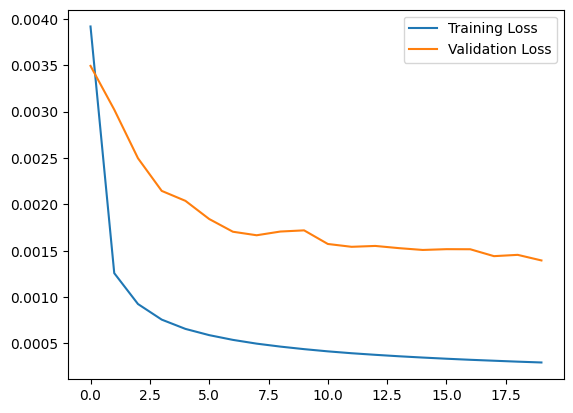

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

##  Threshold Selection

We calculated the reconstruction loss on normal training data, then tested different thresholds using:

**threshold = mean(train_loss) + factor × std(train_loss)**

For each factor (0.5 to 4.0), we computed F1, precision, and recall.  
The best threshold was the one with the highest F1 score.

In [ ]:

reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data).numpy()


reconstructions_train = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data).numpy()


best_factor = None
best_f1 = 0

for factor in np.arange(0.5, 4.1, 0.1):
    threshold = np.mean(train_loss) + factor * np.std(train_loss)
    
    preds = (test_loss > threshold).astype(int)
    
    # نحسب F1 Score
    f1 = f1_score(test_labels, preds)
    precision = precision_score(test_labels, preds)
    recall = recall_score(test_labels, preds)

    print(f"Factor: {factor:.1f} | F1 Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_factor = factor

print(f"\ Best Factor: {best_factor:.1f} --> Best F1 Score: {best_f1:.4f}")

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 234us/step
63427/63427 ━━━━━━━━━━━━━━━━━━━━ 14s 226us/step
Factor: 0.5 | F1 Score: 0.6283 | Precision: 0.4838 | Recall: 0.8958
Factor: 0.6 | F1 Score: 0.6481 | Precision: 0.5099 | Recall: 0.8892
Factor: 0.7 | F1 Score: 0.6701 | Precision: 0.5393 | Recall: 0.8846
Factor: 0.8 | F1 Score: 0.6936 | Precision: 0.5719 | Recall: 0.8811
Factor: 0.9 | F1 Score: 0.7151 | Precision: 0.6028 | Recall: 0.8788
Factor: 1.0 | F1 Score: 0.7321 | Precision: 0.6299 | Recall: 0.8739
Factor: 1.1 | F1 Score: 0.7487 | Precision: 0.6568 | Recall: 0.8703
Factor: 1.2 | F1 Score: 0.7648 | Precision: 0.6833 | Recall: 0.8683
Factor: 1.3 | F1 Score: 0.7777 | Precision: 0.7076 | Recall: 0.8632
Factor: 1.4 | F1 Score: 0.7890 | Precision: 0.7291 | Recall: 0.8596
Factor: 1.5 | F1 Score: 0.7975 | Precision: 0.7495 | Recall: 0.8521
Factor: 1.6 | F1 Score: 0.8044 | Precision: 0.7695 | Recall: 0.8426
Factor: 1.7 | F1 Score: 0.8051 | Precision: 0.7836 | Recall: 0.8278
Factor: 1.8 | F1 Score:

In [ ]:
# حفظ النموذج
autoencoder.save("model_80.99.h5")

In [61]:

autoencoder = load_model("model_80.99.h5")

reconstructions = autoencoder.predict(test_data)

test_loss = tf.keras.losses.mae(reconstructions, test_data).numpy()

reconstructions_train = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data).numpy()


factor = 1.8
threshold = np.mean(train_loss) + factor * np.std(train_loss)
print(f" Threshold using factor {factor}: {threshold:.5f}")


preds = (test_loss > threshold).astype(int)


print(" Evaluation on Test Set:")
print("Precision = {:.4f}".format(precision_score(test_labels, preds)))
print("Recall    = {:.4f}".format(recall_score(test_labels, preds)))
print("F1 Score  = {:.4f}".format(f1_score(test_labels, preds)))

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 1s 239us/step
63415/63415 ━━━━━━━━━━━━━━━━━━━━ 14s 226us/step
 Threshold using factor 1.8: 0.02535
 Evaluation on Test Set:
Precision = 0.7941
Recall    = 0.8263
F1 Score  = 0.8099


In [62]:

df.iloc[[0]].to_json("one_row.json", orient="records", force_ascii=False, indent=4)

In [79]:

row = normal_train_data.iloc[0]

input_data = np.array(row, dtype=np.float32).reshape(1, -1)

reconstructed = autoencoder.predict(input_data)
loss = tf.keras.losses.mae(reconstructed, input_data).numpy().mean()

factor = 1.8
threshold = np.mean(train_loss) + factor * np.std(train_loss)


prediction = "Anomaly" if loss > threshold else "Normal"

print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Normal


In [ ]:

row = anomalous_test_data.iloc[0]

input_data = np.array(row, dtype=np.float32).reshape(1, -1)

reconstructed = autoencoder.predict(input_data)
loss = tf.keras.losses.mae(reconstructed, input_data).numpy().mean()

factor = 1.8
threshold = np.mean(train_loss) + factor * np.std(train_loss)


prediction = "Anomaly" if loss > threshold else "Normal"

print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Anomaly
